In [1]:
from __future__ import print_function
import collections
import numpy as np
import tensorflow as tf
import numpy as np
import zipfile
import pandas as pd
import os
import shutil
import http
import random
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from multiprocessing import Pool, Process
import threading
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
from six.moves.urllib.parse import quote
from sklearn import cross_validation
from random import sample, choice

%matplotlib inline

In [3]:
csv = pd.read_csv('children_de_DE.csv', index_col="imageId")
csv.drop('title', axis=1, inplace=True)
csv.drop('pageURL', axis=1, inplace=True)
csv.drop('imageURL', axis=1, inplace=True)

images = [i[:-4] for i in os.listdir("images_processed/") if i[0] != "."]

csv = csv.loc[images]
csv = csv[csv["breadCrumbs"].notnull()]
def apply(x):
    #return x[-1]
    return x[3] if len(x) > 4 else x[-1]
csv["breadCrumbs"] = csv["breadCrumbs"].str.split("|").apply(apply).astype(int)
print(csv["breadCrumbs"].value_counts()[:20])

161246    3328
161250    2709
161342    1904
177757    1546
161686    1387
161826    1283
161358    1232
161702    1020
161270     977
161314     976
177597     886
177601     821
161478     775
161350     754
161254     749
161902     610
177877     599
172238     593
161338     586
177753     574
Name: breadCrumbs, dtype: int64


In [4]:
#csv2cat = csv[csv["breadCrumbs"].isin([177877,161314])]
csvCat = csv[csv["breadCrumbs"].isin([177877,161314, 161826])] #177877,161314, 161826, 161342, 161270
print(len(csvCat))

2858


In [5]:
#M-WO-KL0008	161314
#M-TS-AST-OPB-SHW	177877
#csv2cat[:5]
#M-SS-SKO-HOO-COF	161342
csvCat[:5]

,sku,breadCrumbs
imageId,,
0017b4d4525773a52be56d3ae91e74e7,M-WO-KL0008,161314
0040c2f8306361fabd4308ff9a01efb7,M-TS-AST-OPB-SHW,177877
004581632879adb4680452094a5e9284,M-TS-WHO-LDS-REB,177877
005c35838740315f2f52f6bf8e8b1e56,M-RL-SBE-0061,161826
005dfd0aa7750a5cf9e528c5bd194988,M-0417-04-020-30009,161314


In [6]:
def img(image_file):
    rgb = ndimage.imread(image_file).astype(float)
    rgb = (rgb - 255.0/2) / 255.0
    return rgb

#csvCat['image'] = [img(os.path.join("images_processed", h+".jpg")) for h in csvCat.index.tolist()]

In [7]:
csvCat.shape

(2858, 2)

In [8]:
X1 = list()
y1 = list()
sku_cat_dict = dict()

i = -1
for h, row in csvCat.iterrows():
    i = i+1
    
    sku_cat_dict[row['sku']] = row["breadCrumbs"]
    
    X1.append(h)
    y1.append(row['sku'])
    if i%500 == 0:
        print(i)
        
#     i = i+1
#     X1[i] = np.fliplr(row['image'])
#     y1.append(row['sku'])
    
X1 = np.array(X1)
y1 = np.array(y1)
del(csv)
del(csvCat)




0
500
1000
1500
2000
2500


In [9]:
X1.shape

(2858,)

In [10]:
triplets = list()
sku_dict = dict()
sku_uniq = list()

for i, sku in enumerate(y1):
    if sku not in sku_dict:
        sku_dict[sku] = list()
        sku_uniq.append(sku)
    sku_dict[sku].append(i)


for sku in sku_uniq:
    lp = sku_dict[sku]
    if len(lp) < 2:
        continue
    for i, skui in enumerate(lp): 
        j = i
        for skun, ln in sku_dict.items():
            if skun == sku:
                continue
            if sku_cat_dict[sku] == sku_cat_dict[skun]:
                continue
            if len(ln) < 2:
                continue
                
            t = np.ndarray(shape=(3,), dtype=np.int64)
            t[0] = skui
            
            while True:
                j = (j+1)%len(lp)
                if j == i:
                    continue
                t[1] = lp[j]
                break
            t[2] = ln[np.random.randint(len(ln))]
            
            triplets.append(t)
            
            
    
triplets = np.array(triplets)
print(len(triplets))
mask = np.random.choice([False, True], len(triplets), p=[0.9, 0.1])
triplets = triplets[mask]
print(len(triplets))

with open("sku_uniq.pickle", 'wb') as f:
    pickle.dump(sku_uniq, f, pickle.HIGHEST_PROTOCOL)

1079119
107803


In [11]:
cat_labels = [sku_cat_dict[sku] for sku in sku_uniq]
cat_uniq = np.unique(np.array(cat_labels))

cat_id_labels = [np.nonzero(cat_uniq==cat_id)[0][0] for cat_id in cat_labels]
cat_id_labels = np.array(cat_id_labels).astype(int)

cat_labels_full = [sku_cat_dict[sku] for sku in y1]
cat_id_labels_full = [np.nonzero(cat_uniq==cat_id)[0][0] for cat_id in cat_labels_full]
cat_id_labels_full = np.array(cat_id_labels_full).astype(int)


In [12]:
np.unique(np.array(cat_labels))

array([161314, 161826, 177877])

In [13]:
cat_id_labels_full.shape

(2858,)

In [14]:
triplets

array([[   0, 1554, 1205],
       [   0, 1554, 1700],
       [   0, 1554, 2763],
       ..., 
       [2789, 2715, 2717],
       [2789, 2715, 2839],
       [2789, 2715, 1025]])

In [15]:
sku_uniq[:5]
#M-WO-KL0008	161314 - 2
#M-TS-AST-OPB-SHW	177877 - 4
#M-SS-SKO-HOO-COF	161342 - 0

['M-WO-KL0008',
 'M-TS-AST-OPB-SHW',
 'M-TS-WHO-LDS-REB',
 'M-RL-SBE-0061',
 'M-0417-04-020-30009']

In [16]:
len(sku_uniq)

710

In [17]:
len(sku_dict)

710

In [18]:
len(triplets)

107803

In [19]:
np.random.shuffle(triplets)


In [20]:
def print_tf(w):
    print(w.device, w.name, w.get_shape().as_list())

In [21]:
def wb(wshape=[None],bshape=[None], device='/cpu:0'):
    with tf.device(device):
        w = tf.get_variable("w", wshape, initializer=tf.truncated_normal_initializer(stddev=0.1))
        b = tf.get_variable('b', bshape, initializer=tf.constant_initializer(0.0))
    print_tf(w)
    print_tf(b)
    return w, b

In [22]:
def get_img_list(ids):
    imgs = np.ndarray(shape=(len(ids), 128,128,3), dtype=np.float32)
    for i, h in enumerate(ids):
        imgs[i] = img(os.path.join("images_processed", h+".jpg"))
    return imgs

In [31]:
# Deep ranking
# http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf

# Swap https://www.digitalocean.com/community/tutorials/how-to-configure-virtual-memory-swap-file-on-a-vps
image_size = 128
num_channels = 3
margin = 0.5
batch_size = 16
num_classes = len(sku_dict)
embedding_size = 4096
l2_reg_norm = 5e-4

tf.reset_default_graph() 
graph_con = tf.Graph()
with graph_con.as_default():

    # Input data.
    X_q   = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    X_pos = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    X_neg = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
#     y_tf  = tf.placeholder(tf.int64, shape=(batch_size,))
    
    X_eval   = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    

  
    # Variables
    with tf.variable_scope("convNetConvLayer1"): 
        layer1_weights, layer1_biases = wb([3, 3, 3, 16], [16], device="/job:ps/task:0")
    with tf.variable_scope("convNetConvLayer2"):
        layer2_weights,layer2_biases = wb([3, 3, 16, 64], [64], device="/job:ps/task:0")
    with tf.variable_scope("convNetFCLayer3"):
        layer3_weights, layer3_biases = wb(
            [image_size // 4 * image_size // 4 * 64 , embedding_size], [embedding_size], device="/job:ps/task:0")

    
    def convNetModel(data, train=False):

        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, layer1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        pool1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm1')
        print_tf(pool1)

        conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, layer2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        pool2 = tf.nn.lrn(pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm2')
        print_tf(pool2)

        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [-1, np.prod(shape[1:])])
        if train:
            reshape = tf.nn.dropout(reshape, 0.6)
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases, name='convNetModel_out')
        hidden = tf.nn.l2_normalize(hidden,1, name='convNetModel_out_norm')

        return hidden

    with tf.device("/job:worker/task:0"):
    #with tf.device('/job:local/task:0/device:cpu:0'):
        out_pos = convNetModel(X_pos, True)
    #with tf.device('/cpu:0'):
    with tf.device("/job:worker/task:1"):
        out_neg = convNetModel(X_neg, True)
    # Logits.
    #with tf.device('/job:ps/task:0'):
        out_q = convNetModel(X_q, True)
        out_eval = convNetModel(X_eval)
        
        print_tf(out_q)
        print_tf(out_pos)
        print_tf(out_neg)
     

  
        scores_pos = tf.reduce_sum(tf.square(out_q - out_pos), 1, name="scores_pos")
        scores_neg = tf.reduce_sum(tf.square(out_q - out_neg), 1, name="scores_neg")
        print_tf(scores_pos)
        print_tf(scores_neg)
        
#     with tf.device('/cpu:0'):
# http://stackoverflow.com/questions/38270166/tensorflow-max-margin-loss-training
# http://stackoverflow.com/questions/37689632/max-margin-loss-in-tensorflow
        loss_matrix = tf.maximum(0., margin + scores_pos - scores_neg)  # we could also use tf.nn.relu here
        print("loss_matrix", loss_matrix.get_shape().as_list())
        loss_data = tf.reduce_sum(loss_matrix)
    
    # classification loss (crazy idea)
#     class_logits = tf.matmul(out_q, layer4_weights) + layer4_biases
#     loss_class = tf.reduce_mean(
#         tf.nn.sparse_softmax_cross_entropy_with_logits(class_logits, y_tf), 
#         name='class_cross_entropy'
#     )
    
    # L2 regularization for the fully connected parameters.
#     with tf.device('/gpu:0'): 
        regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
                        tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + 
                        tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases))
        loss_l2 = l2_reg_norm * regularizers
        # Add the regularization term to the loss.
        loss = loss_data + loss_l2
    
        tf.scalar_summary('loss_data', loss_data)
        tf.scalar_summary('loss_l2', loss_l2)
        tf.scalar_summary('loss', loss)
    
#     with tf.device('/cpu:0'):
        # Optimizer.
        global_step = tf.Variable(0, trainable=False)
        learn_rate  = tf.train.exponential_decay(.01, global_step*batch_size, len(triplets)//2, 0.5, staircase=True) # <-- learning rate
        tf.scalar_summary('learning_rate', learn_rate)
        optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss, global_step=global_step, name = "AdamOptimizer")
        print(optimizer.name, optimizer.device)
        #optimizer   = tf.train.MomentumOptimizer(learn_rate, 0.9).minimize(loss, global_step=global_step)
    


/job:ps/task:0 convNetConvLayer1/w:0 [3, 3, 3, 16]
/job:ps/task:0 convNetConvLayer1/b:0 [16]
/job:ps/task:0 convNetConvLayer2/w:0 [3, 3, 16, 64]
/job:ps/task:0 convNetConvLayer2/b:0 [64]
/job:ps/task:0 convNetFCLayer3/w:0 [65536, 4096]
/job:ps/task:0 convNetFCLayer3/b:0 [4096]
/job:worker/task:0 norm1:0 [16, 64, 64, 16]
/job:worker/task:0 norm2:0 [16, 32, 32, 64]
/job:worker/task:1 norm1_1:0 [16, 64, 64, 16]
/job:worker/task:1 norm2_1:0 [16, 32, 32, 64]
/job:worker/task:1 norm1_2:0 [16, 64, 64, 16]
/job:worker/task:1 norm2_2:0 [16, 32, 32, 64]
/job:worker/task:1 norm1_3:0 [None, 64, 64, 16]
/job:worker/task:1 norm2_3:0 [None, 32, 32, 64]
/job:worker/task:1 convNetModel_out_norm_2:0 [16, 4096]
/job:worker/task:0 convNetModel_out_norm:0 [16, 4096]
/job:worker/task:1 convNetModel_out_norm_1:0 [16, 4096]
/job:worker/task:1 scores_pos:0 [16]
/job:worker/task:1 scores_neg:0 [16]
loss_matrix [16]
AdamOptimizer /job:worker/task:1


In [32]:
len(triplets)//batch_size

6737

In [33]:
num_steps = (len(triplets)//batch_size)
print("Steps", num_steps)

tf.reset_default_graph() 
with tf.Session("grpc://localhost:2222", graph=graph_con) as session:
    merged = tf.merge_all_summaries()
    train_writer = tf.train.SummaryWriter('./logs/train', session.graph)
    
    init_op = tf.initialize_all_variables()
    saver = tf.train.Saver()
    init_op.run()
    print("Initialized valiables")
    
    for step in range(num_steps):
        offset = (step * batch_size) % (len(triplets) - batch_size)
        batch_triplets = triplets[offset:(offset + batch_size), :]

        feed_dict = {
            X_q   : get_img_list(X1[batch_triplets[:,0]]),
#             y_tf  : cat_id_labels_full[batch_triplets[:,0]],
            X_pos : get_img_list(X1[batch_triplets[:,1]]), 
            X_neg : get_img_list(X1[batch_triplets[:,2]])
        }
        t = datetime.datetime.now()
        summary, _, l, ld, l2, sp, sn = session.run([merged, optimizer, loss, loss_data, loss_l2, scores_pos, scores_neg], feed_dict=feed_dict)
        train_writer.add_summary(summary, step)
        total_seconds = (datetime.datetime.now()-t).total_seconds()

        if step < 20 or step % 10 == 0:
            print("Step", step, ", took", total_seconds, "seconds")
            print("loss", l, " -> data:", ld, ", l2:",l2)

        if step % 50 == 0 and step > 1:
            print(sp)
            print(sn, "\n")
            
    print("training done, check")
    sku0, sku1 = sku_uniq[0], sku_uniq[1]
    print("> sku0:", sku0, "sku1:", sku1)
    idx = sku_dict[sku0][:2] + sku_dict[sku1][:1]
    emb_list = session.run(out_eval, feed_dict={X_eval:X1[idx]})
    print( emb_list)
    sp, sn = np.sum(np.square(emb_list[0] - emb_list[1])), np.sum(np.square(emb_list[0] - emb_list[2]))
    print("> positive dist:", sp, "negative dist:", sn)
        
    
    print("check done, calculating embeddings")         
    embeddings_np = np.ndarray(shape=(len(sku_dict),embedding_size), dtype=np.float32)

    for i, sku in enumerate(sku_uniq):
        feed_dict = {X_eval:X1[sku_dict[sku]]}
        embeddings_np[i] = session.run(tf.reduce_mean(out_eval, 0), feed_dict=feed_dict)
        if i == 0:
            print("> mean dist for first sku:", np.sum(np.square(emb_list[0] - embeddings_np[i])))
    norm = np.sqrt(np.sum(np.square(embeddings_np), axis=1))
    norm[norm == 0] = 1
    norm = norm[:,None]
    embeddings_np = embeddings_np/norm
    
    print("calculating embeddings done")
    
    print("check similarity")
    print("sku0", sku_uniq[0], sku_dict[sku_uniq[0]][:2], sku_dict[sku_uniq[0]][0])
    print("sku1", sku_uniq[1], sku_dict[sku_uniq[1]][:2], sku_dict[sku_uniq[1]][0])
    # http://stackoverflow.com/questions/37558899/efficiently-finding-closest-word-in-tensorflow-embedding
    imgid = sku_dict[sku_uniq[0]][0]
    imgid1 = sku_dict[sku_uniq[1]][0]
    print("imgids", imgid, imgid1)
    img = np.concatenate((X1[imgid:imgid+1], X1[imgid1:imgid1+1]), axis=0)
    feed_dict = {X_eval:img}
    check_embeddings = session.run(out_eval, feed_dict=feed_dict)
    print("> check_embeddings.shape", check_embeddings.shape)
    print("> embeddings_np.T", embeddings_np.T.shape)
    similarity = np.dot(check_embeddings, embeddings_np.T)
    for i, sim in enumerate(similarity):
        closest = sim.argsort()[-10:]
        print("> closest i ",i," >>", y1[imgid], closest, [sku_uniq[i] for i in closest])
    
    
#     save_path = saver.save(session, "visualsearch_deep_ranking_2c.ckpt")
#     pickle_file = "visualsearch_deep_ranking_embeddings_mom_2c.pickle"
#     try:
#         with open(pickle_file, 'wb') as f:
#             pickle.dump(embeddings_np, f, pickle.HIGHEST_PROTOCOL)
#     except Exception as e:
#         print('Unable to save data to', pickle_file, ':', e)
        
#     print("saved")
        

Steps 6737
Initialized valiables
Step 0 , took 35.278354 seconds
loss 521.246  -> data: 6.88883 , l2: 514.357
Step 1 , took 36.65965 seconds
loss 466.266  -> data: 7.92562 , l2: 458.341


KeyboardInterrupt: 

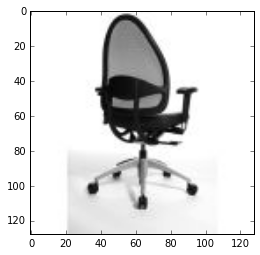

In [21]:
plt.imshow(X1[2]+128.0)

In [28]:
sku_dict["M-HK-WTI-MEX-COU"][:4]

[192, 193, 484, 485]

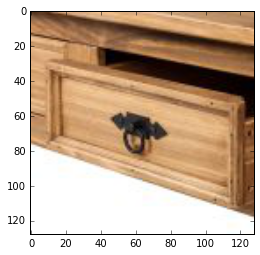

In [29]:
plt.imshow(X1[192]+128.0)

In [30]:
sku_dict["M-TS-AST-XPA-SHW"][:4]

[244, 245, 530, 531]

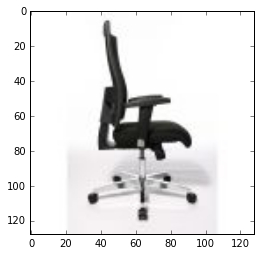

In [31]:
plt.imshow(X1[244]+128.0)

In [32]:
y1[:10]

['M-WO-KL0008',
 'M-WO-KL0008',
 'M-TS-AST-OPB-SHW',
 'M-TS-AST-OPB-SHW',
 'M-TS-WHO-LDS-REB',
 'M-TS-WHO-LDS-REB',
 'M-0417-04-020-30009',
 'M-0417-04-020-30009',
 'M-TS-AST-ALB-AGR',
 'M-TS-AST-ALB-AGR']

In [46]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(np.array(labels)))))
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y, color=colors[label])
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

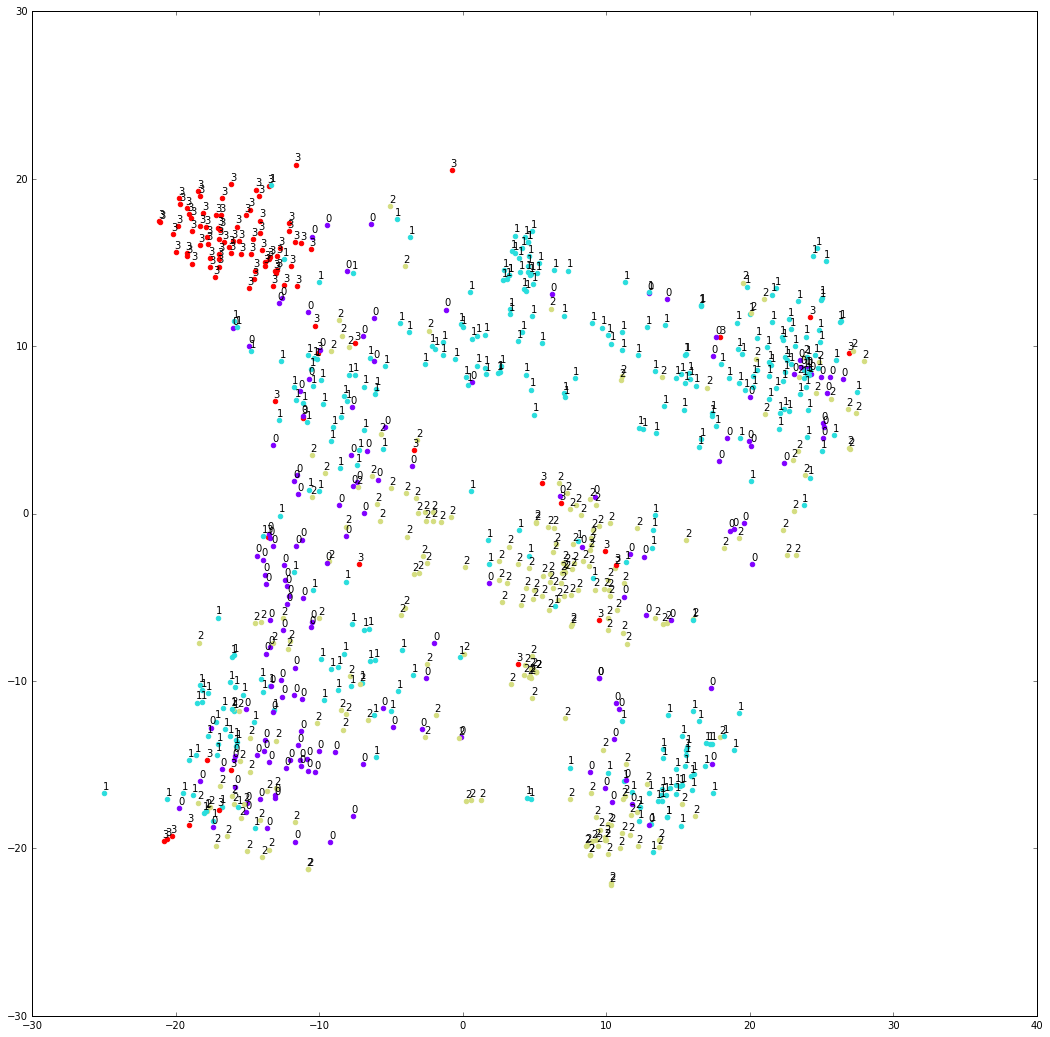

In [69]:
model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = model.fit_transform(embeddings_np)

plot_with_labels(low_dim_embs, cat_id_labels)